In [1]:
# Do all the imports, with some code copy&paste clutter for convenience. 



import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # noqa:E402

import argparse
import json

import tensorflow.compat.v1 as tf

tf.logging.set_verbosity(tf.logging.ERROR)  # noqa:E402

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

DEFAULT_MODEL_PATH = os.path.join("infer_model/model", "model.pb")
DEFAULT_LABELMAP_PATH = os.path.join("infer_model/model", "labelmap.pbtxt")


def load_inference_graph(frozen_graph_path: str) -> tf.Graph:
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(frozen_graph_path, "rb") as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name="")

    return detection_graph


def image_to_nparray(image: Image) -> np.ndarray:
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)


def build_tensor_dict():
    # Get handles to input and output tensors
    ops = tf.get_default_graph().get_operations()
    all_tensor_names = {output.name for op in ops for output in op.outputs}
    tensor_dict = {}

    important_keys = [
        "num_detections",
        "detection_boxes",
        "detection_scores",
        "detection_classes",
    ]
    for key in important_keys:
        tensor_name = key + ":0"
        if tensor_name in all_tensor_names:
            tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)

    return tensor_dict


def convert_types(output_dict):
    output_dict["num_detections"] = int(output_dict["num_detections"][0])
    output_dict["detection_classes"] = output_dict["detection_classes"][0].astype(
        np.int64
    )
    output_dict["detection_boxes"] = output_dict["detection_boxes"][0]
    output_dict["detection_scores"] = output_dict["detection_scores"][0]


def run_session(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            tensor_dict = build_tensor_dict()
            image_tensor = tf.get_default_graph().get_tensor_by_name("image_tensor:0")

            # Run inference
            output_dict = sess.run(tensor_dict, feed_dict={image_tensor: image})

            # All outputs are float32 numpy arrays, so convert types as appropriate
            convert_types(output_dict)

    return output_dict


def output_to_json(output_from_network, thresh=0.6):
    boxes = output_from_network["detection_boxes"]
    scores = output_from_network["detection_scores"]
    classes = output_from_network["detection_classes"]

    boxes = boxes[scores > thresh]
    classes = classes[scores > thresh]
    scores = scores[scores > thresh]

    return json.dumps(
        {
            "boxes": boxes.tolist(),
            "scores": scores.tolist(),
            "classes": classes.tolist(),
        },
        sort_keys=True,
        indent=4,
    )


def run_inference(
    image: Image,
    model_path: str,
    labelmap_path: str,
    threshold: float,
    output_path: str = None,
) -> dict:
    """Runs model inference on provided image."""
    # The array based representation of the image will be used later in order
    # to prepare the result image with boxes and labels on it
    image_np = image_to_nparray(image)

    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)

    # Load frozen graph
    graph = load_inference_graph(model_path)

    # Actual detection
    output_dict = run_session(image_np_expanded, graph)

    if output_path is not None:
        category_index = label_map_util.create_category_index_from_labelmap(
            labelmap_path, use_display_name=True
        )

        # Visualization of the results of a detection
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            output_dict["detection_boxes"],
            output_dict["detection_classes"],
            output_dict["detection_scores"],
            category_index,
            instance_masks=output_dict.get("detection_masks"),
            use_normalized_coordinates=True,
            line_thickness=1,
        )
        dpi = 300.0
        fig = plt.figure(frameon=False, dpi=dpi)
        fig.set_size_inches(image_np.shape[1] / dpi, image_np.shape[0] / dpi)
        ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
        ax.set_axis_off()
        fig.add_axes(ax)
        ax.imshow(image_np)
        fig.savefig(output_path, bbox_inches="tight", pad_inches=0, dpi="figure")
        plt.close(fig)

    return output_to_json(output_dict, threshold)

ModuleNotFoundError: No module named 'tensorflow'

In [8]:
# Preprocess dataset with the given model. This is time consuming and should be done only once.

import json


input_folder = 'infer_model/PortElizibethWebcam'
images = os.listdir(input_folder)

output_folder = 'infer_model/output'
json_folder = 'infer_model/output_json'

counter = 0
for image_file in images:
    counter += 1
    result = run_inference(
        Image.open(os.path.join(input_folder, image_file)),
        threshold=0.6,
        model_path=DEFAULT_MODEL_PATH,
        labelmap_path=DEFAULT_LABELMAP_PATH,
        output_path=os.path.join(output_folder, image_file)
        )
    
    with open(os.path.join(json_folder, image_file[:-3] + 'json'), 'w', encoding='utf-8') as f:
        json.dump(result, f, indent=4)

    print("%s/%s" % (str(counter), str(len(images))) )
    


1/2166
2/2166
3/2166
4/2166
5/2166
6/2166
7/2166
8/2166
9/2166
10/2166
11/2166
12/2166
13/2166
14/2166
15/2166
16/2166
17/2166
18/2166
19/2166
20/2166
21/2166
22/2166
23/2166
24/2166
25/2166
26/2166
27/2166
28/2166
29/2166
30/2166
31/2166
32/2166
33/2166
34/2166
35/2166
36/2166
37/2166
38/2166
39/2166
40/2166
41/2166
42/2166
43/2166
44/2166
45/2166
46/2166
47/2166
48/2166
49/2166
50/2166
51/2166
52/2166
53/2166
54/2166
55/2166
56/2166
57/2166
58/2166
59/2166
60/2166
61/2166
62/2166
63/2166
64/2166
65/2166
66/2166
67/2166
68/2166
69/2166
70/2166
71/2166
72/2166
73/2166
74/2166
75/2166
76/2166
77/2166
78/2166
79/2166
80/2166
81/2166
82/2166
83/2166
84/2166
85/2166
86/2166
87/2166
88/2166
89/2166
90/2166
91/2166
92/2166
93/2166
94/2166
95/2166
96/2166
97/2166
98/2166
99/2166
100/2166
101/2166
102/2166
103/2166
104/2166
105/2166
106/2166
107/2166
108/2166
109/2166
110/2166
111/2166
112/2166
113/2166
114/2166
115/2166
116/2166
117/2166
118/2166
119/2166
120/2166
121/2166
122/2166
123/2166
1

924/2166
925/2166
926/2166
927/2166
928/2166
929/2166
930/2166
931/2166
932/2166
933/2166
934/2166
935/2166
936/2166
937/2166
938/2166
939/2166
940/2166
941/2166
942/2166
943/2166
944/2166
945/2166
946/2166
947/2166
948/2166
949/2166
950/2166
951/2166
952/2166
953/2166
954/2166
955/2166
956/2166
957/2166
958/2166
959/2166
960/2166
961/2166
962/2166
963/2166
964/2166
965/2166
966/2166
967/2166
968/2166
969/2166
970/2166
971/2166
972/2166
973/2166
974/2166
975/2166
976/2166
977/2166
978/2166
979/2166
980/2166
981/2166
982/2166
983/2166
984/2166
985/2166
986/2166
987/2166
988/2166
989/2166
990/2166
991/2166
992/2166
993/2166
994/2166
995/2166
996/2166
997/2166
998/2166
999/2166
1000/2166
1001/2166
1002/2166
1003/2166
1004/2166
1005/2166
1006/2166
1007/2166
1008/2166
1009/2166
1010/2166
1011/2166
1012/2166
1013/2166
1014/2166
1015/2166
1016/2166
1017/2166
1018/2166
1019/2166
1020/2166
1021/2166
1022/2166
1023/2166
1024/2166
1025/2166
1026/2166
1027/2166
1028/2166
1029/2166
1030/2166
1031/2

1751/2166
1752/2166
1753/2166
1754/2166
1755/2166
1756/2166
1757/2166
1758/2166
1759/2166
1760/2166
1761/2166
1762/2166
1763/2166
1764/2166
1765/2166
1766/2166
1767/2166
1768/2166
1769/2166
1770/2166
1771/2166
1772/2166
1773/2166
1774/2166
1775/2166
1776/2166
1777/2166
1778/2166
1779/2166
1780/2166
1781/2166
1782/2166
1783/2166
1784/2166
1785/2166
1786/2166
1787/2166
1788/2166
1789/2166
1790/2166
1791/2166
1792/2166
1793/2166
1794/2166
1795/2166
1796/2166
1797/2166
1798/2166
1799/2166
1800/2166
1801/2166
1802/2166
1803/2166
1804/2166
1805/2166
1806/2166
1807/2166
1808/2166
1809/2166
1810/2166
1811/2166
1812/2166
1813/2166
1814/2166
1815/2166
1816/2166
1817/2166
1818/2166
1819/2166
1820/2166
1821/2166
1822/2166
1823/2166
1824/2166
1825/2166
1826/2166
1827/2166
1828/2166
1829/2166
1830/2166
1831/2166
1832/2166
1833/2166
1834/2166
1835/2166
1836/2166
1837/2166
1838/2166
1839/2166
1840/2166
1841/2166
1842/2166
1843/2166
1844/2166
1845/2166
1846/2166
1847/2166
1848/2166
1849/2166
1850/2166


In [545]:
# Load every bounding box from the data. 
# Vehicle is in the lane if lower edge midpoint is between the lane edges.

import json

json_folder = 'infer_model/output_json'

data_files = os.listdir(json_folder)

x = []
y = []

for json_file in data_files:
    with open(os.path.join(json_folder, json_file), 'r') as f:
        data = json.load(f)
            
        classes = data['classes']
        scores = data['scores']
        for i in range(len(classes)):
            if classes[i] == 1 and scores[i] > 0.999:
                box = data['boxes'][i]
                x.append((box[1] + box[3])/2) # We take the midpoint of the lower edge.
                y.append(box[0])
        

x = np.array(x)
y = np.array(y)


print(x)
print(y)


[0.46803279 0.59459665 0.80009311 ... 0.73223731 0.15758392 0.07032195]
[0.52159333 0.35644931 0.38184106 ... 0.25070077 0.32444179 0.51350915]


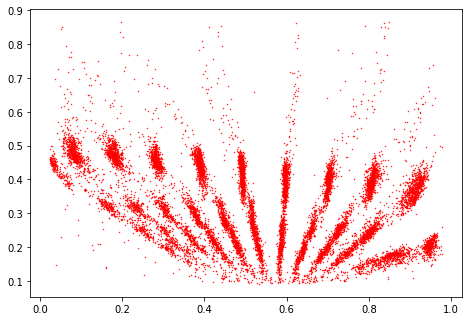

In [525]:
# Display historical positions of the lower edge midpoint. 

import matplotlib.pyplot as plt

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(x, y, color='r', s=0.2)
plt.show()

In [544]:
# Stack both coordinates together. 

X = np.vstack([x, y]).T

X.shape

(14956, 2)

In [505]:
# In order to fit lines to this dataset, we must first discretize it in order to used existing Hough transform library.

from skimage.transform import hough_line, hough_line_peaks
from skimage.draw import line
from skimage import filters
from skimage.morphology import erosion, square, binary_erosion

shape = (300, 300)
X_img = np.zeros(shape, dtype=np.bool)

X_index = X*np.array(shape)
X_index = X_index.astype(np.int16)

X_img[X_index[:, 0], X_index[:, 1]] = True

# No need for additional preprocessing, but may increase performance for some other dataset.
#X_img = binary_erosion(X_img, np.array([[0,0,0],[1,1,1], [0,0,0]])) 

X_img = X_img.astype(np.int8)

plt.figure(figsize=shape)
plt.imshow(X_img)
plt.show()

[[140 156]
 [178 106]
 [240 114]
 ...
 [219  75]
 [ 47  97]
 [ 21 154]]


In [542]:
# Here we fit lines that correspond to lanes. 
# This is accomplished by using Hough transform and some hyperparameter tunning. 
# We also use 2 facts to prune excess lines extensively:
# Fact A: lanes must meet at the vanishing point at the horizont.
# Fact B: camera is cropped and focused on the lanes, so any vehicles going outside of the image on the mid-line is an outlier.

hspace, angles, dists = hough_line(X_img, theta=np.pi * np.arange(0.22, 0.90, 0.001))

h, a, d = hough_line_peaks(hspace, angles, dists, min_angle=20, threshold=0.01*np.max(hspace)) # Hyperparameters empirically tuned.

horizon = [167, 0] # Hyperparameter, approximate position of the vanishing point.
vp_threshold = 15 # Hyperparameter, threshold to cutoff all lines that do not go through vp.
mid_horizon = [167, 130] # Hyperparameter, used to prune any erroneous lines. 

# Y coordinate at the horizon (image is rotated 90).
y0 = (d - horizon[1] * np.cos(a)) / np.sin(a) 

# Prune every line that misses the vp.
true_lines = np.abs(y0 - horizon[0]) < vp_threshold

h = h[true_lines]
a = a[true_lines]
d = d[true_lines]


# Y coordinate at the mid horizon (image is rotated 90).
y_m = (d - mid_horizon[1] * np.cos(a)) / np.sin(a) 

# Prune any lines that go out of the screen; those are not the lanes we are interested in.
true_lines = (y_m > 0) * (y_m < 300)


y_m = y_m[true_lines]
h = h[true_lines]
a = a[true_lines]
d = d[true_lines]

# Sort all lanes (lines), so that we can enumerate the lanes correctly. 
line_indices = np.argsort(y_m)

y_m = y_m[line_indices]
h = h[line_indices]
a = a[line_indices]
d = d[line_indices]


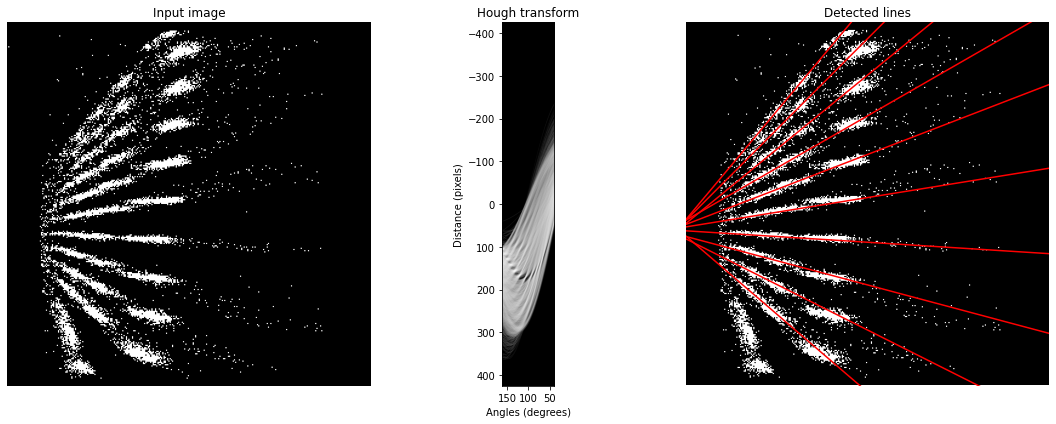

In [543]:
# Now we plot lines that we fitted on the data.

from matplotlib import cm

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

X_img2 = X_img.copy()
X_img2[20, 1] = 1
ax[0].imshow(X_img2, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + hspace),
             extent=[np.rad2deg(angles[-1]), np.rad2deg(angles[0]), dists[-1], dists[0]],
             cmap=cm.gray, aspect=1/1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(X_img, cmap=cm.gray)
origin = np.array((0, X_img.shape[1]))
for _, angle, dist in zip(h,a,d):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    
    ax[2].plot(origin, (y0, y1), '-r')
ax[2].set_xlim(origin)
ax[2].set_ylim((X_img.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

In [538]:
# Main code for inference; Parameters angles and distances must be saved/loaded to/from DB or some env variable

def predict_proba(points, angles, distances):
    """ Predicts probabilities that a point belongs to a lane (for each lane). 
    

    """
    n_points = points.shape[0]
    n_lines = len(angles)
    
    cost = np.tile(np.cos(angles), (n_points, 1))
    sint = np.tile(np.sin(angles), (n_points, 1))
    
    r = np.tile(distances, (n_points, 1))
    x = np.tile(points[:,0], (n_lines, 1)).T
    y = np.tile(points[:,1], (n_lines, 1)).T
    
    # Distance to lines represented with (angle,distance).
    d = r - (x * cost + y * sint)
    
    # Drop the sign.
    d = np.sqrt(d*d)    
    
    # Calculate sigmoid based on distance from each line.
    e = np.exp(-d)
    
    return e / np.tile(np.sum(e, axis=1), (n_lines,1)).T
    
def predict(points, angles, distances):
    """ Returns the most probable lane for points. 
    
    """
    probs = predict_proba(points, angles, distances)
    
    return np.argmax(probs, axis=1)


def predict_vehicle_lane(json_data, angles, distances, vehicle_class=1, score_threshold=0.999, scale=(300,300)):
    """ Returns the most probable lane for each vehicle on the image.
    
    """
    x = []
    y = []
    
    classes = data['classes']
    scores = data['scores']
    for i in range(len(classes)):
        if classes[i] == vehicle_class and scores[i] > score_threshold:
            box = data['boxes'][i]
            x.append((box[1] + box[3])/2) # We take the midpoint of the lower edge.
            y.append(box[0])

    x = np.array(x) * scale[0]
    y = np.array(y) * scale[1]
    
    X = np.vstack([y, scale[0] - x]).T # Convert to image coordinates.
    
    return predict(X, angles, distances)
    
    

In [539]:
# Generate samples in order to plot decision boundary.
samplex, sampley = np.meshgrid(np.arange(300), np.arange(300))

samplex = samplex.flatten()
sampley = sampley.flatten()
samplex = samplex * 1
sampley = sampley * 1

sample = np.vstack([samplex, sampley]).T

print(sample.shape)

sample_lanes = predict(sample, a, d)

print(sample_lanes)

(90000, 2)
[0 0 0 ... 8 8 8]


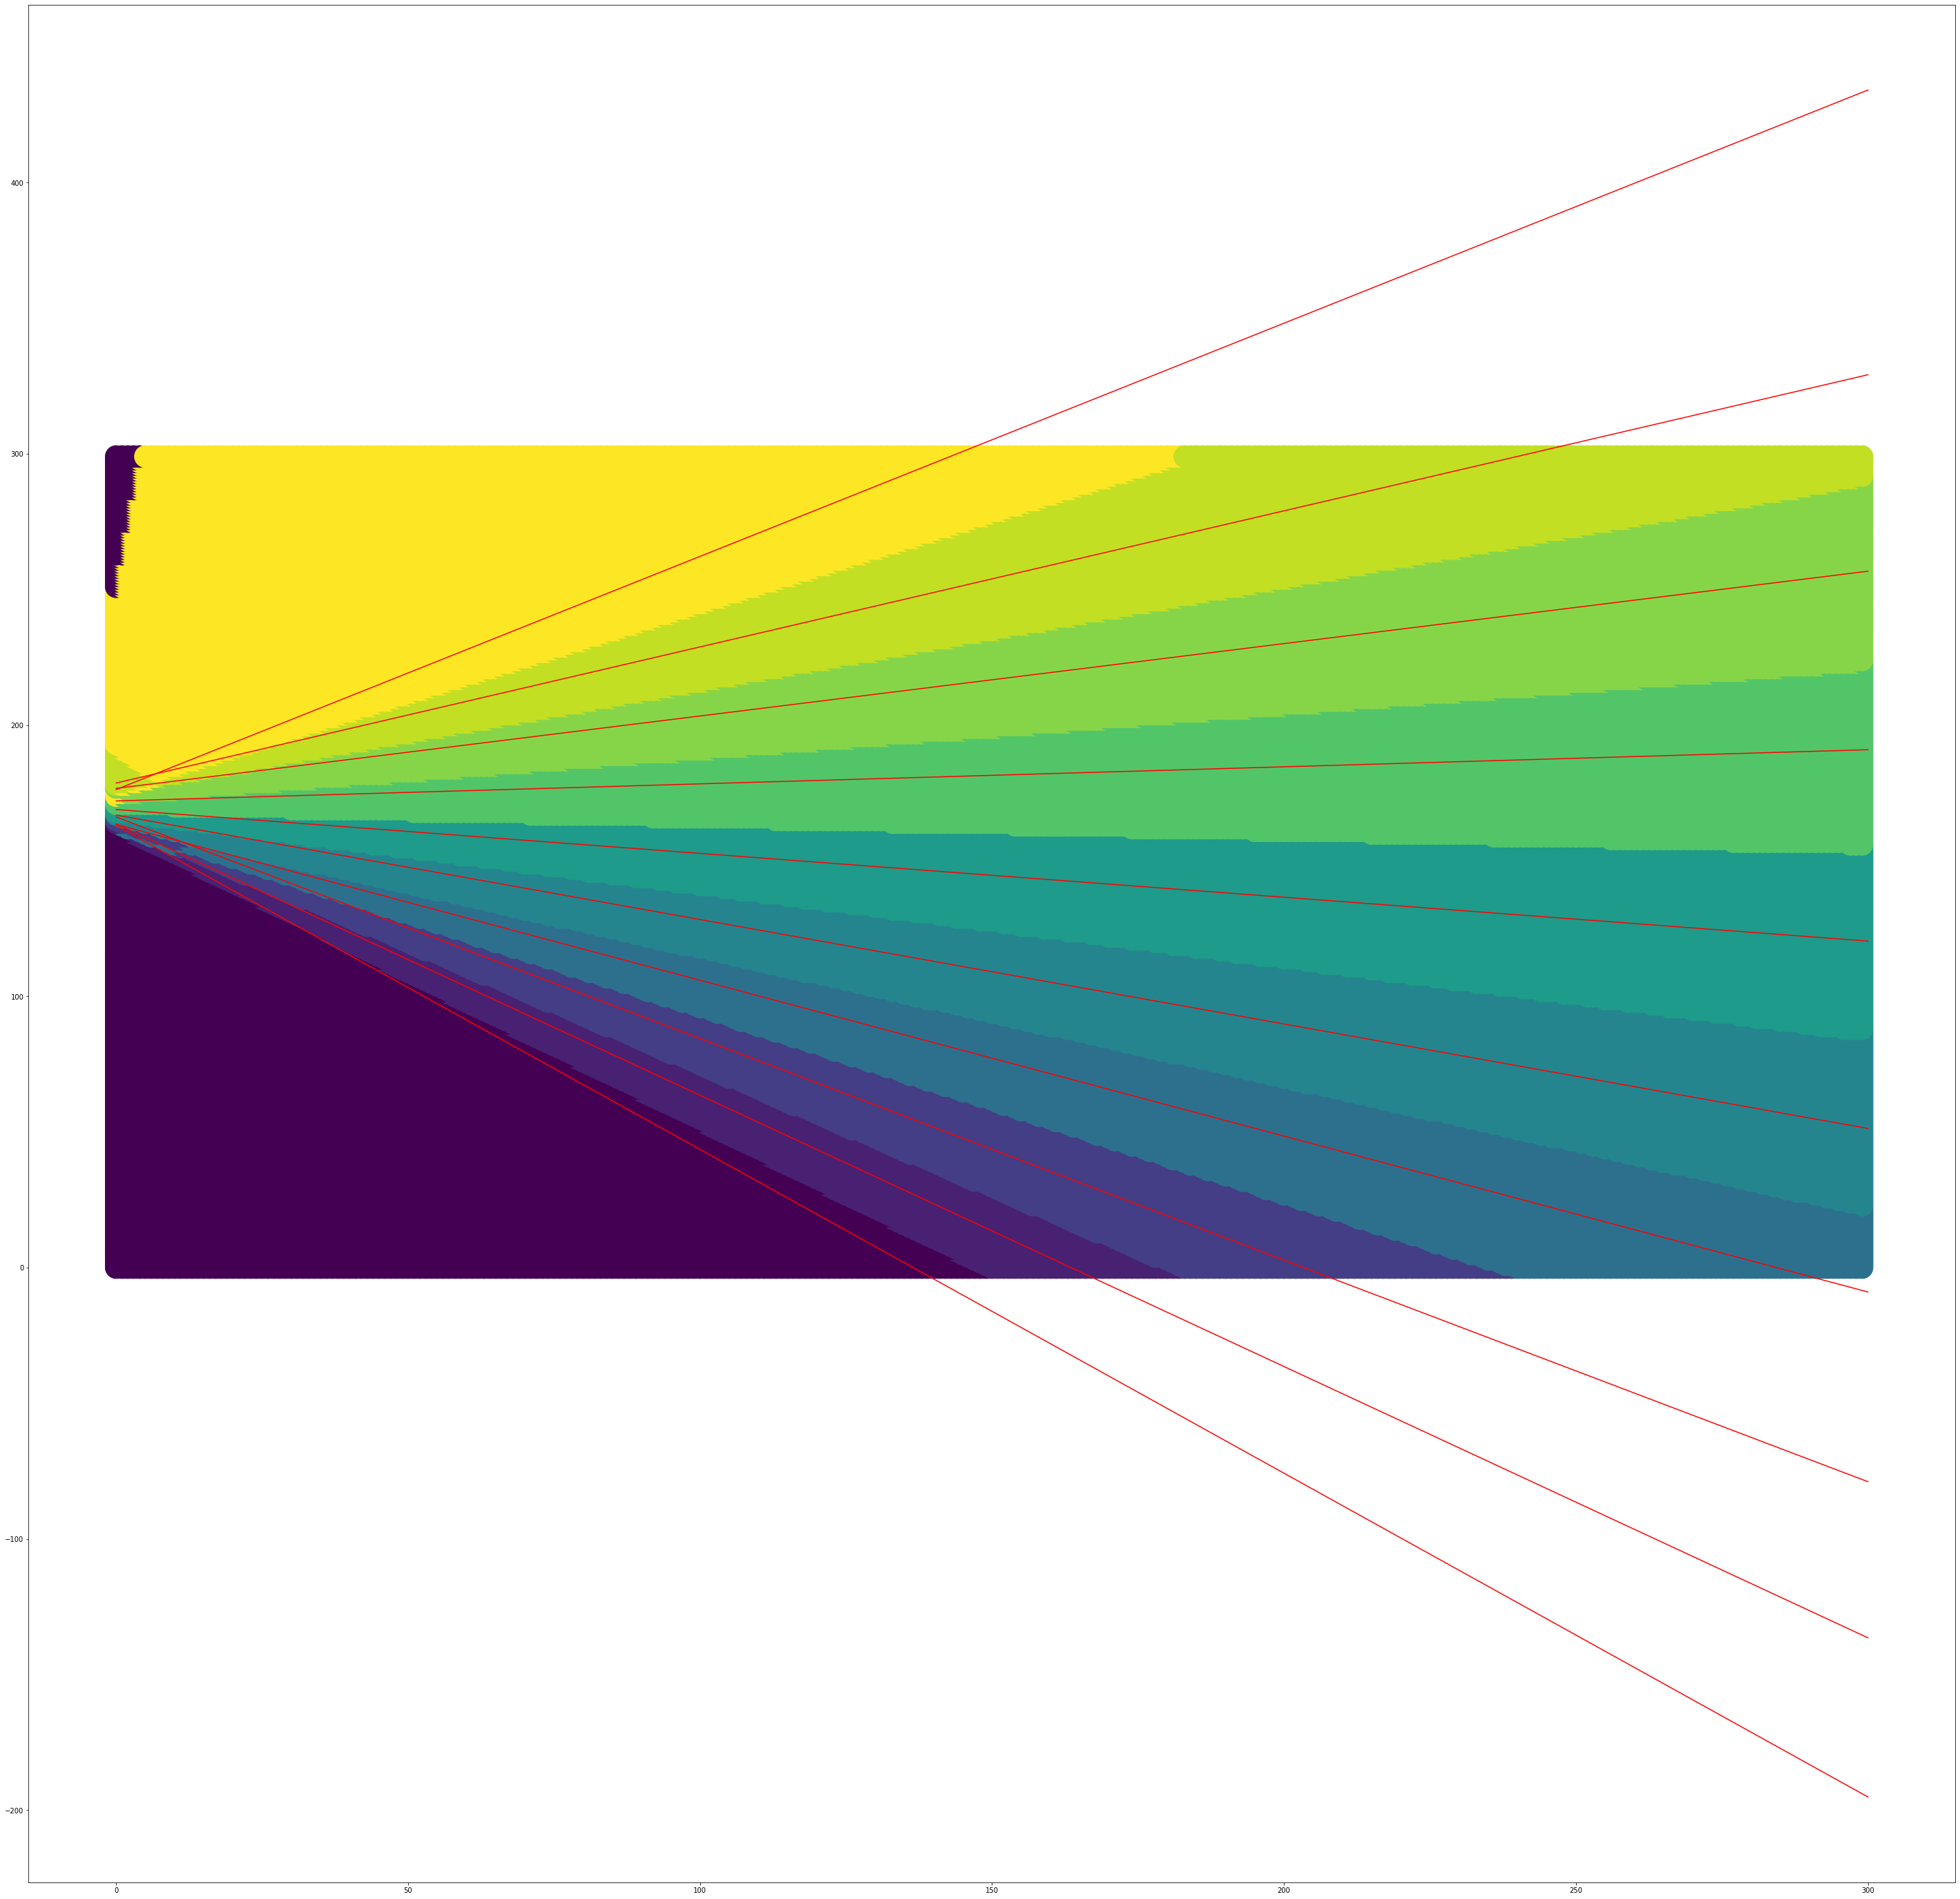

In [540]:
# Decision boundary demonstration (image is rotated 90 degrees, since coordinates are in image coordinate system.)
from matplotlib import cm

viridis = cm.get_cmap('viridis', 12)


fig=plt.figure(figsize=(50,50))
plt.scatter(sample[:,0], sample[:,1],  c=sample_lanes, cmap=viridis, s=1000)

for _, angle, dist in zip(h,a,d):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    
    plt.plot(origin, (y0, y1), '-r')

plt.show()


In [541]:
# Example usage (in order to work, parameters a and d must be loaded):

for json_file in data_files:
    with open(os.path.join(json_folder, json_file), 'r') as f:
        data = json.load(f)
            
        lanes = predict_vehicle_lane(data, a, d)
    
        print(json_file + ' ' + str(lanes))
    

port_elizibeth_webcam_2018-10-15T18-30-02.json [5 4 1 7 8 2 8 0 5 9 0 5 0 7 0 1 4 0 3 8]
port_elizibeth_webcam_2018-10-15T18-52-02.json [0 9 8 1 5 6 7 4 3 4 2 6 2 5 5 0 0 8]
port_elizibeth_webcam_2018-10-15T10-40-02.json [9 7 2 6 8 0 5 0 5 6 7 3]
port_elizibeth_webcam_2018-10-15T23-30-02.json []
port_elizibeth_webcam_2018-10-16T23-52-02.json []
port_elizibeth_webcam_2018-10-18T06-56-01.json []
port_elizibeth_webcam_2018-10-15T15-34-02.json [3 8 0 8 7 0 8 6 2 1 0 6 0]
port_elizibeth_webcam_2018-10-15T19-44-01.json [2 5 6 7 0 4 3 0 6 8 0 2 9 6 9]
port_elizibeth_webcam_2018-10-16T12-56-01.json [0]
port_elizibeth_webcam_2018-10-17T20-24-01.json [8 1 5 7 5 0 3 2 4 0]
port_elizibeth_webcam_2018-10-15T18-20-02.json [4 7 0 0 6 3 2 8 0 5 2 8 6 2 9 5 8 0 0]
port_elizibeth_webcam_2018-10-18T03-28-01.json []
port_elizibeth_webcam_2018-10-15T19-52-01.json [8 4 1 7 5 5 7 9 9 6 6 8]
port_elizibeth_webcam_2018-10-15T20-42-02.json [8 9]
port_elizibeth_webcam_2018-10-16T05-40-01.json []
port_elizibeth_w

port_elizibeth_webcam_2018-10-18T04-38-01.json []
port_elizibeth_webcam_2018-10-15T23-16-02.json []
port_elizibeth_webcam_2018-10-18T04-00-01.json []
port_elizibeth_webcam_2018-10-16T23-14-01.json []
port_elizibeth_webcam_2018-10-17T11-46-01.json [5 2 3 1 0 4 6 8 8 1 5 0 0 6 7 6 0 0 8 9 0]
port_elizibeth_webcam_2018-10-15T22-12-01.json []
port_elizibeth_webcam_2018-10-15T20-44-01.json [8]
port_elizibeth_webcam_2018-10-16T04-20-01.json []
port_elizibeth_webcam_2018-10-18T08-54-01.json []
port_elizibeth_webcam_2018-10-16T13-08-01.json [5 9 0 0 0 9 1]
port_elizibeth_webcam_2018-10-16T16-14-01.json [0 6 4 0 3 6 2 8 8 9 7 5 4 1 5 0 5 0 7 8 0]
port_elizibeth_webcam_2018-10-16T00-58-02.json []
port_elizibeth_webcam_2018-10-16T18-04-02.json [0 0 8 6 4 0 5 7 0 2 2 1 9 4 5 0]
port_elizibeth_webcam_2018-10-17T23-24-02.json []
port_elizibeth_webcam_2018-10-16T18-58-01.json [8 9 4 2 0 5 6 3 7 0 6 5 0 3 6 7 0]
port_elizibeth_webcam_2018-10-15T20-16-02.json [0 1 7 6]
port_elizibeth_webcam_2018-10-16T

port_elizibeth_webcam_2018-10-18T08-16-01.json []
port_elizibeth_webcam_2018-10-16T21-04-01.json []
port_elizibeth_webcam_2018-10-16T09-56-01.json [9 8 0 1 4 6 5 7 3 2 8 6 0 0 0 1 4 5]
port_elizibeth_webcam_2018-10-17T10-46-02.json [0 8 6 3 2 5 4 1 5 0 1 7 6 0]
port_elizibeth_webcam_2018-10-16T00-56-01.json []
port_elizibeth_webcam_2018-10-15T19-54-02.json [0 2 6 8 5 3 7 7 4 4 6 8 9 8 9]
port_elizibeth_webcam_2018-10-16T10-24-02.json [0 3 2 7 4 5 8 6]
port_elizibeth_webcam_2018-10-15T19-34-01.json [4 4 7 0 6 1 0 0 2 2 9 0 9 5 0 8 7 9 6 0 3]
port_elizibeth_webcam_2018-10-17T02-30-01.json []
port_elizibeth_webcam_2018-10-16T06-52-02.json [0]
port_elizibeth_webcam_2018-10-17T17-22-02.json [7 4 8 6 3 7 4 6 8 0 1 6 0 3 6 9]
port_elizibeth_webcam_2018-10-16T09-14-01.json [5]
port_elizibeth_webcam_2018-10-16T10-38-01.json [4 2 6 7 3 8 0 6 5]
port_elizibeth_webcam_2018-10-17T16-20-01.json [1 8 3 3 5 7 6 4 8 7 8 9 0 0 0 0 8 1 7 4]
port_elizibeth_webcam_2018-10-16T09-34-02.json [2 8 6 2 4 4 6 5 

port_elizibeth_webcam_2018-10-17T04-54-02.json []
port_elizibeth_webcam_2018-10-17T13-32-02.json [4 9 2 6 6 3 7 0 5 0 0 0 4 0 7 4]
port_elizibeth_webcam_2018-10-16T23-56-02.json []
port_elizibeth_webcam_2018-10-17T08-08-01.json []
port_elizibeth_webcam_2018-10-16T03-48-02.json []
port_elizibeth_webcam_2018-10-16T10-28-02.json [3 5 1 8 7 4 6 0 6 8 0 5 2 0 0 1]
port_elizibeth_webcam_2018-10-15T13-52-02.json [0 5 2 6 0 2]
port_elizibeth_webcam_2018-10-17T20-38-02.json [2 0 6 2 5 7 9 8]
port_elizibeth_webcam_2018-10-16T04-06-02.json []
port_elizibeth_webcam_2018-10-16T23-44-02.json []
port_elizibeth_webcam_2018-10-18T09-26-02.json [6 1 9 7 0 8]
port_elizibeth_webcam_2018-10-15T18-02-02.json [8 0 1 4 9 6 2 3 6 5 5 1 0 0 5 8 7 0 9 3 0]
port_elizibeth_webcam_2018-10-15T17-20-01.json [5 0 7 6 8 0 0 2 0 3 9 4 4 9 6 9]
port_elizibeth_webcam_2018-10-16T04-52-01.json []
port_elizibeth_webcam_2018-10-16T16-04-01.json [7 3 7 5 5 4 3 0 0 9 8 1 0 0 0 6]
port_elizibeth_webcam_2018-10-17T14-14-02.json [

port_elizibeth_webcam_2018-10-16T07-36-01.json []
port_elizibeth_webcam_2018-10-17T21-10-01.json [0 1]
port_elizibeth_webcam_2018-10-16T07-10-01.json []
port_elizibeth_webcam_2018-10-18T02-54-01.json []
port_elizibeth_webcam_2018-10-17T12-32-02.json [8 7 8 5 1 4 3 1 5 6 1]
port_elizibeth_webcam_2018-10-16T03-30-01.json []
port_elizibeth_webcam_2018-10-15T12-06-02.json [8 6 7 3 0 6 5 2 5 9 4 8 0 0 8 2 0 7 0 0 0 2 6 4 0 7]
port_elizibeth_webcam_2018-10-18T01-06-01.json []
port_elizibeth_webcam_2018-10-17T12-04-02.json [8 6 5 0 9 7 0 6 8 0 8 2 7 0 3 0 2]
port_elizibeth_webcam_2018-10-16T16-02-02.json [1 8 0 1 7 6 5 1 0 0 0 5 3 4 4 0 5 8 6]
port_elizibeth_webcam_2018-10-17T03-26-01.json []
port_elizibeth_webcam_2018-10-15T18-48-01.json [8 1 7 5 2 6 3 6 0 6 0 2 5 2 4 4 7 1 9 0]
port_elizibeth_webcam_2018-10-16T17-12-02.json [1 5 9 4 6 0 8 9 0 5 0 2 8 2 0 7 3 8 0]
port_elizibeth_webcam_2018-10-17T03-16-01.json []
port_elizibeth_webcam_2018-10-15T20-32-02.json [0]
port_elizibeth_webcam_2018-1

port_elizibeth_webcam_2018-10-16T04-02-01.json []
port_elizibeth_webcam_2018-10-17T06-42-01.json []
port_elizibeth_webcam_2018-10-18T01-58-02.json []
port_elizibeth_webcam_2018-10-16T08-26-01.json []
port_elizibeth_webcam_2018-10-15T16-04-02.json [7 0 0 3 4 9 5 0 8 2 0 1 0 0 7 5 4 8 6 6]
port_elizibeth_webcam_2018-10-15T13-06-02.json [8]
port_elizibeth_webcam_2018-10-17T23-08-02.json []
port_elizibeth_webcam_2018-10-17T07-56-01.json []
port_elizibeth_webcam_2018-10-16T00-18-02.json []
port_elizibeth_webcam_2018-10-15T14-58-02.json [0 6 9 8 0]
port_elizibeth_webcam_2018-10-17T03-28-02.json []
port_elizibeth_webcam_2018-10-17T14-38-01.json [2 4 3 5 6 4 8 0 3 0 6 7 5 8 0 9 1 7]
port_elizibeth_webcam_2018-10-15T13-56-02.json [3 5 8 5 0 9 6 7 4]
port_elizibeth_webcam_2018-10-16T11-10-02.json [3 0 7 6]
port_elizibeth_webcam_2018-10-16T08-12-02.json []
port_elizibeth_webcam_2018-10-17T23-04-01.json []
port_elizibeth_webcam_2018-10-15T14-14-02.json [4 1 6 7 8 9]
port_elizibeth_webcam_2018-10-1